# Setup

### Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values

# Custom utils
from utils.utils_data import *
from utils.utils_plot import *

### Define some paths and constants.

In [2]:
config = dotenv_values(".env")

# Paths
PATH_ERA5 = config['PATH_ERA5']
PATH_EOBS = config['PATH_EOBS']

# Options
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
LONS_PREC = [-25, 30]
LATS_PREC = [30, 75]
PRECIP_DATA = 'ERA5-low' # Options: ERA5-hi, ERA5-low, E-OBS
PRECIP_XTRM = 0.95 # Percentile (threshold) for the extremes

# Analyze precipitation

## Plot precipitation thresholds

In [3]:
# Load precipitation
if PRECIP_DATA == 'ERA5-hi':
    pr = get_nc_data(PATH_ERA5 + '/precipitation/orig_grid/daily/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.tp
elif PRECIP_DATA == 'ERA5-low':
    pr = get_nc_data(PATH_ERA5 + '/precipitation/day_grid1/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.tp
elif PRECIP_DATA in ['E-OBS', 'EOBS']:
    pr = get_nc_data(PATH_EOBS + '/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.rr
    pr = pr.coarsen(lon=5, lat=5, boundary="trim").mean()
    pr = pr.fillna(0) # Over the seas. Not optimal...
else:
    raise ValueError('Precipitation data not well defined')

Extracting data for the period 1979-01-01 - 2020-12-31


In [4]:
# Compute the extreme exceedence
q95 = xr.DataArray(pr).quantile(0.95, dim='time')
q98 = xr.DataArray(pr).quantile(0.98, dim='time')
q99 = xr.DataArray(pr).quantile(0.99, dim='time')
pr_95 = xr.DataArray(pr > q95)
pr_98 = xr.DataArray(pr > q98)
pr_99 = xr.DataArray(pr > q99)

In [5]:
# Extract coordinates for precip
lats_y = pr.lat.to_numpy()
lons_y = pr.lon.to_numpy()

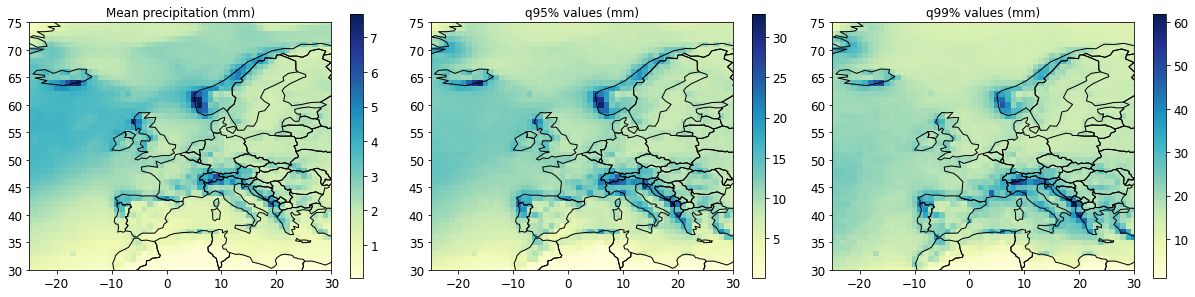

In [6]:
# Plot precip, threshold exceedance and threshold values
fig, axs = plt.subplots(1, 3, figsize=(17,4))

plot_map(axs[0], lons_y, lats_y, pr.mean(dim='time').to_numpy().squeeze(), title="Mean precipitation (mm)", cmap=mpl.cm.YlGnBu)
plot_map(axs[1], lons_y, lats_y, q95.to_numpy().squeeze(), title="q95% values (mm)", cmap=mpl.cm.YlGnBu)
plot_map(axs[2], lons_y, lats_y, q99.to_numpy().squeeze(), title="q99% values (mm)", cmap=mpl.cm.YlGnBu)
plt.tight_layout()

plt.savefig('figures/map_precipitation.pdf')